In [1]:
import pandas as pd
import numpy as np
import pandas_profiling

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [50]:
import math

In [143]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

In [2]:
pd.set_option("display.max_rows",50)
pd.set_option("display.max_columns",30)

In [3]:
dataset=pd.read_csv('data.csv')
submission=pd.read_csv('sample_submission.csv')

In [4]:
dataset.shape

(30697, 28)

In [5]:
dataset['shot_id_number']=range(1,len(dataset['shot_id_number'])+1)

In [6]:
submission.head()

,shot_id_number,is_goal
0,1,0.1
1,8,0.1
2,17,0.1
3,20,0.1
4,33,0.1


In [7]:
output_label='is_goal'

In [9]:
dataset.isnull().sum()

Unnamed: 0                   0
match_event_id            1563
location_x                1461
location_y                1540
remaining_min             1562
power_of_shot             1486
knockout_match            1517
game_season               5862
remaining_sec             1594
distance_of_shot          1567
is_goal                   6268
area_of_shot              1502
shot_basics               1575
range_of_shot             1564
team_name                 1535
date_of_game              1550
home/away                 1497
shot_id_number               0
lat/lng                   1565
type_of_shot             15280
type_of_combined_shot    15417
match_id                     0
team_id                      0
remaining_min.1           1535
power_of_shot.1           1539
knockout_match.1          1493
remaining_sec.1           1539
distance_of_shot.1        1568
dtype: int64

In [12]:
del dataset['Unnamed: 0']

In [17]:
def rank_transformation_on_match_event_in_match_id(data):
    xm=data.groupby(['match_id'])
    ut = list(xm.groups.keys())
    finals_club=pd.DataFrame()
    for i in ut:
        df=xm.get_group(i)
        rank_length=len(df)
        df['match_event_id']=range(1,rank_length+1)
        finals_club=pd.concat([finals_club,df])
    return finals_club

In [18]:
dataset.isnull().sum()

match_event_id            1563
location_x                1461
location_y                1540
remaining_min             1562
power_of_shot             1486
knockout_match            1517
game_season               5862
remaining_sec             1594
distance_of_shot          1567
is_goal                   6268
area_of_shot              1502
shot_basics               1575
range_of_shot             1564
team_name                 1535
date_of_game              1550
home/away                 1497
shot_id_number               0
lat/lng                   1565
type_of_shot             15280
type_of_combined_shot    15417
match_id                     0
team_id                      0
remaining_min.1           1535
power_of_shot.1           1539
knockout_match.1          1493
remaining_sec.1           1539
distance_of_shot.1        1568
dtype: int64

In [19]:
dataset=rank_transformation_on_match_event_in_match_id(dataset)

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
def change_remain(x,y):
    if x==y:
        return x
    elif (int(x)==x)& (x!=-99.0):
        return x
    elif (int(y)==y) & (y!=-99.0):
        return y
    else:
        return x

In [27]:
dataset['remaining_min.1']=dataset['remaining_min.1'].fillna(-99.0)
dataset['remaining_min']=dataset['remaining_min'].fillna(-99.0)
dataset['remaining_min_f']=dataset.apply(lambda x: change_remain(x['remaining_min'],x['remaining_min.1']),axis=1)

In [30]:
dataset['remaining_sec.1']=dataset['remaining_sec.1'].fillna(-99.0)
dataset['remaining_sec']=dataset['remaining_sec'].fillna(-99.0)
dataset['remaining_sec_f']=dataset.apply(lambda x: change_remain(x['remaining_sec'],x['remaining_sec.1']),axis=1)

In [31]:
dataset['power_of_shot.1']=dataset['power_of_shot.1'].fillna(-99.0)
dataset['power_of_shot']=dataset['power_of_shot'].fillna(-99.0)
dataset['power_of_shot_f']=dataset.apply(lambda x: change_remain(x['power_of_shot'],x['power_of_shot.1']),axis=1)

In [32]:
dataset['knockout_match.1']=dataset['knockout_match.1'].fillna(-99.0)
dataset['knockout_match']=dataset['knockout_match'].fillna(-99.0)
dataset['knockout_match_f']=dataset.apply(lambda x: change_remain(x['knockout_match'],x['knockout_match.1']),axis=1)

In [33]:
dataset['distance_of_shot.1']=dataset['distance_of_shot.1'].fillna(-99.0)
dataset['distance_of_shot']=dataset['distance_of_shot'].fillna(-99.0)
dataset['distance_of_shot_f']=dataset.apply(lambda x: change_remain(x['distance_of_shot'],x['distance_of_shot.1']),axis=1)

In [34]:
def fill_data_with_corresponding_values(df,a1,b1):
    fill_table=pd.DataFrame(columns=[a1,b1+'_fill'])
    for x in df[a1].unique().tolist():
        if len(df.loc[(df[a1]==x)&(~df[b1].isnull()),b1])!=0:
            x_value=df.loc[(df[a1]==x)&(~df[b1].isnull()),b1].values[0]
        else:
            x_value=np.nan
        df2 = pd.DataFrame({a1:[x], b1+'_fill':[x_value]}) 
        fill_table=fill_table.append(df2)
    fill_table[a1]=fill_table[a1].astype(int).astype(str)
    df[a1]=df[a1].astype(int).astype(str)
    return pd.merge(df,fill_table,how='left',on=a1)    

In [35]:
dataset=fill_data_with_corresponding_values(dataset,'match_id','date_of_game')

In [38]:
dataset.date_of_game_fill.isnull().sum()

1

In [41]:
dataset['game_season_f']=pd.to_datetime(dataset['date_of_game_fill']).dt.year

In [44]:
mini=pd.to_datetime(dataset['date_of_game_fill']).min()

In [45]:
def change_to_int(x):
    try:
        return int(x)
    except:
        return 0

In [47]:
dataset['date_of_game_f']=(pd.to_datetime(dataset['date_of_game_fill'])-mini).apply(lambda x: change_to_int(str(x).split()[0]))

In [51]:
def fill_range(distance,range_of_shot):
    if (range_of_shot=='empty'):
        if (distance==-99.0):
            return np.nan
        elif (distance<=28.0)&(distance>0.0):
            return 'Less Than 8 ft.'
        elif (distance<=36.0):
            return '8-16 ft.'
        elif (distance<=43.0):
            return '16-24 ft.'
        elif (distance<=65.0):
            return '24+ ft.'
        elif (distance>65.0):
            return 'Back Court Shot'
    else:
        return range_of_shot

In [53]:
dataset['range_of_shot']=dataset['range_of_shot'].fillna('empty')
dataset['range_of_shot_fill']=dataset.apply(lambda x: fill_range(x['distance_of_shot_f'],x['range_of_shot']),axis=1)

In [54]:
dataset['type_of_shot'].isnull().sum()

15280

In [55]:
dataset['type_of_combined_shot'].isnull().sum()

15417

In [56]:
dataset['type_of_shot_cfill']=dataset['type_of_shot'].apply(str).apply(lambda x: 'empty' if (x=='nan') else 'c_'+x)
dataset['type_of_shot_fill']=dataset['type_of_shot'].fillna('empty')

In [57]:
dataset['type_of_combined_shot_fill']=dataset['type_of_combined_shot'].fillna('empty')

In [59]:
dataset['shot_type_comb']=np.where(dataset['type_of_combined_shot_fill']=='empty',dataset['type_of_shot_fill'],dataset['type_of_combined_shot_fill'])

In [60]:
dataset['shot_type_diff']=np.where(dataset['type_of_combined_shot_fill']=='empty',dataset['type_of_shot_cfill'],dataset['type_of_combined_shot_fill'])

In [61]:
train=dataset[~dataset[output_label].isnull()]
test=dataset[dataset[output_label].isnull()]

In [63]:
train['is_goal'].value_counts(dropna=False,normalize=True)

0.0    0.554669
1.0    0.445331
Name: is_goal, dtype: float64

In [64]:
train.shape

(24429, 41)

In [65]:
test.shape

(6268, 41)

In [66]:
lam=train.groupby(['shot_basics','area_of_shot'],as_index=False).agg({'location_x':{'min','max'},'location_y':{'min','max'}})
lam.columns=['shot_basics','area_of_shot','xmax','xmin','ymax','ymin']

In [68]:
def change_area_of_shot(data,table):
    New_Data=pd.DataFrame(columns=data.columns.tolist())
    for index,row in data.iterrows():
        if (row['area_of_shot']!='empty'):
            New_Data=pd.concat([New_Data,pd.DataFrame(row).T],axis=0)
        else:
            if (row['shot_basics']=='empty'):
                New_Data=pd.concat([New_Data,pd.DataFrame(row).T],axis=0)
            else:
                space=table[table['shot_basics']==row['shot_basics']]
                flag=0
                for index_space,row_space in space.iterrows():
                    if ((row['location_x']<=row_space['xmax'])& (row['location_x']>=row_space['xmin']) & (row['location_y']<=row_space['ymax'])& (row['location_y']>=row_space['ymin'])):
                        row['area_of_shot']=row_space['area_of_shot']
                        New_Data=pd.concat([New_Data,pd.DataFrame(row).T],axis=0)
                        flag=1
                        break
                if flag==0:
                    New_Data=pd.concat([New_Data,pd.DataFrame(row).T],axis=0)    
    return New_Data

In [69]:
dataset['area_of_shot']=dataset['area_of_shot'].fillna('empty')
dataset['shot_basics']=dataset['shot_basics'].fillna('empty')

In [70]:
dataset=change_area_of_shot(dataset,lam)

In [71]:
lad=train.groupby(['area_of_shot','shot_basics'],as_index=False).agg({'location_x':{'min','max'},'location_y':{'min','max'}})
lad.columns=['area_of_shot','shot_basics','xmax','xmin','ymax','ymin']

In [72]:
nlad=lad[(lad['area_of_shot']!='empty')&(lad['shot_basics']!='empty')]

In [74]:
def change_shot_basics(data,table):
    New_Data=pd.DataFrame(columns=data.columns.tolist())
    for index,row in data.iterrows():
        if (row['shot_basics']!='empty'):
            New_Data=pd.concat([New_Data,pd.DataFrame(row).T],axis=0)
        else:
            if (row['area_of_shot']=='empty'):
                New_Data=pd.concat([New_Data,pd.DataFrame(row).T],axis=0)
            else:
                space=table[table['area_of_shot']==row['area_of_shot']]
                flag=0
                for index_space,row_space in space.iterrows():
                    if ((row['location_x']<=row_space['xmax'])& (row['location_x']>=row_space['xmin']) & (row['location_y']<=row_space['ymax'])& (row['location_y']>=row_space['ymin'])):
                        row['shot_basics']=row_space['shot_basics']
                        New_Data=pd.concat([New_Data,pd.DataFrame(row).T],axis=0)
                        flag=1
                        break
                if flag==0:
                    New_Data=pd.concat([New_Data,pd.DataFrame(row).T],axis=0)    
    return New_Data

In [75]:
dataset=change_shot_basics(dataset,nlad)

In [76]:
loc_x=dataset[~dataset.location_x.isnull()]
loc_x['location_x']=loc_x['location_x'].astype(int)
x_table=loc_x.groupby(['shot_basics','area_of_shot'],as_index=False).location_x.median()
x_table.columns=['shot_basics', 'area_of_shot', 'fill_x']
dataset=pd.merge(dataset,x_table,how='left',on=['shot_basics','area_of_shot'])
dataset.loc[dataset.location_x.isnull(),'location_x']=dataset.loc[dataset.location_x.isnull(),'fill_x']

In [77]:
loc_y=dataset[~dataset.location_y.isnull()]
loc_y['location_y']=loc_y['location_y'].astype(int)
y_table=loc_y.groupby(['shot_basics','area_of_shot'],as_index=False).location_y.median()
y_table.columns=['shot_basics', 'area_of_shot', 'fill_y']
dataset=pd.merge(dataset,y_table,how='left',on=['shot_basics','area_of_shot'])
dataset.loc[dataset.location_y.isnull(),'location_y']=dataset.loc[dataset.location_y.isnull(),'fill_y']

In [95]:
dataset['location_x']=dataset['location_x'].astype(int)
dataset['location_y']=dataset['location_y'].astype(int)

In [96]:
def create_angle(x,y):
    if x==0:
        return 0
    return y/x

In [97]:
dataset['shot_angle']=dataset.apply(lambda x:create_angle(x['location_x'],x['location_y']),axis=1)

In [100]:
dataset['shot_distance']=np.sqrt(np.power(dataset['location_x'],2)+np.power(dataset['location_y'],2))

In [101]:
dataset.to_csv('preprocessed_dataset.csv')

In [371]:
cols=['match_event_id','location_x','location_y','is_goal','area_of_shot','shot_basics','shot_id_number',
      'match_id','remaining_min_f','remaining_sec_f','power_of_shot_f','knockout_match_f',
      'distance_of_shot_f','game_season_f','date_of_game_f','range_of_shot_fill',
      'shot_type_comb','shot_type_diff','shot_angle','shot_distance','range_of_shot']

In [372]:
main_data=dataset[cols]

In [613]:
num=['location_x','location_y',#,'remaining_min_f',
     #'remaining_sec_f',
     'power_of_shot_f',#'knockout_match_f',
     'distance_of_shot_f'#'game_season_f'
     ,'date_of_game_f'
     ,'shot_angle','shot_distance']#,'match_event_id']
cat=['match_event_id','area_of_shot','shot_basics','range_of_shot','shot_type_comb','shot_type_diff','match_id']
id_col='shot_id_number'
output='is_goal'

## split

In [444]:
main_data['range_of_shot']=main_data['range_of_shot'].fillna('empty')

In [445]:
main_data['game_season_f']=main_data['game_season_f'].fillna(0)

In [377]:
main_data['shot_id_number']=main_data['shot_id_number'].astype(int)
int_cols=['location_x','location_y','remaining_min_f','remaining_sec_f','power_of_shot_f','knockout_match_f',
      'distance_of_shot_f','game_season_f','date_of_game_f','match_event_id']
for x in int_cols:
    main_data[x]=main_data[x].astype(int)

In [378]:
train=main_data[~main_data[output_label].isnull()]
test=main_data[main_data[output_label].isnull()]

In [379]:
train['is_goal']=train['is_goal'].astype(int)

In [566]:
train['two_level']=train['shot_basics']+'_'+train['area_of_shot']
train['two_level_enc']=train.two_level.map(train.groupby(['two_level']).is_goal.mean())
test['two_level']=test['shot_basics']+'_'+test['area_of_shot']
test['two_level_enc']=test['two_level'].map(train.groupby(['two_level']).is_goal.mean())

In [579]:
train['two_level_A']=train['range_of_shot']+'_'+train['area_of_shot']
train['two_level_A_enc']=train.two_level_A.map(train.groupby(['two_level_A']).is_goal.mean())
test['two_level_A']=test['range_of_shot']+'_'+test['area_of_shot']
test['two_level_A_enc']=test['two_level_A'].map(train.groupby(['two_level_A']).is_goal.mean())

In [602]:
train['t_sec']=(train['remaining_min_f']*60)+train['remaining_sec_f']

In [604]:
test['t_sec']=(test['remaining_min_f']*60)+test['remaining_sec_f']

In [380]:
train['range_of_shot_enc']=train.range_of_shot.map(train.groupby(['range_of_shot']).is_goal.mean())
train['match_id_enc']=train.match_id.map(train.groupby(['match_id']).is_goal.mean())
train['shot_type_comb_enc']=train.shot_type_comb.map(train.groupby(['shot_type_comb']).is_goal.mean())
train['shot_type_diff_enc']=train.shot_type_diff.map(train.groupby(['shot_type_diff']).is_goal.mean())
train['shot_basics_enc']=train.shot_basics.map(train.groupby(['shot_basics']).is_goal.mean())
train['area_of_shot_enc']=train.area_of_shot.map(train.groupby(['area_of_shot']).is_goal.mean())
train['match_event_id_enc']=train.match_event_id.map(train.groupby(['match_event_id']).is_goal.mean())

In [381]:
for m in cat:
    test[m+'_enc']=test[m].map(train.groupby([m]).is_goal.mean())

In [614]:
features=num+['range_of_shot_enc',#'shot_type_comb_enc',
              'shot_type_diff_enc',
              'match_event_id_enc',
              'shot_basics_enc',
              'area_of_shot_enc',
              'match_id_enc','two_level_enc','t_sec'
             ]

# scoring

In [434]:
def printing_Kfold(x_data,y_data,seed=2,split=10):
    skf = StratifiedKFold(n_splits=split,shuffle=True,random_state=seed)
    metric_score = []
    for train_index,test_index in skf.split(x_data,y_data):
        X_train, X_test = x_data[train_index], x_data[test_index]
        y_train, y_test = y_data[train_index], y_data[test_index]
        lr=lgb.LGBMClassifier()
        #lr = RandomForestClassifier(n_estimators=100,max_depth=10,min_samples_leaf=50,random_state=seed)
        #lr=GradientBoostingClassifier(n_estimators=200,random_state=2,min_samples_split=40,max_depth=7,subsample=0.8,learning_rate=0.05)
        lr.fit(X_train,y_train)
        pred = lr.predict(X_test)
        pred_prob = lr.predict_proba(X_test)[:,1]
        MAE=mean_absolute_error(y_test,pred_prob)
        score=1/(1+MAE)
        metric_score.append(score)
    print("average scores:")
    print(sum(metric_score)/len(metric_score))

In [384]:
printing_Kfold(train[features].values,train['is_goal'].values)
#average scores:
#0.6964531011183455

/home/divyam.arora/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/divyam.arora/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/divyam.arora/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/divyam.arora/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth valu

average scores:
0.7025178785473759


/home/divyam.arora/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/divyam.arora/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# subimission

In [279]:
from sklearn.ensemble import GradientBoostingClassifier

In [356]:
import lightgbm as lgb

In [536]:
import xgboost as xgb

In [545]:
param_xgb={'max_depth':range(3,13,2),
          'min_child_weight':range(1,20,2),
           'gamma':[i/10.0 for i in range(0,8)],
           'subsample':[i/10.0 for i in range(6,10)],
           'colsample_bytree':[i/10.0 for i in range(6,10)],
           'reg_alpha':[1e-5,1e-2,0.1,1,100,0.05,0.01],
           'learning_rate':[0.1,0.01,0.001,0.005,0.03,0.03,0.04,0.003,0.002]
          }

In [546]:
rf=xgb.XGBClassifier(learning_rate=0.1,n_estimators=1000,max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,
                    colsample_bytree=0.8,objective='binary:logistic',seed=2)
n_HP_points_to_test = 20
gs = RandomizedSearchCV(
    estimator=rf, param_distributions=param_xgb, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=2,
    verbose=True)

In [549]:
gs.fit(train[features],train['is_goal'])
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 13.7min finished


Best score reached: 0.6947662961852485 with params: {'subsample': 0.6, 'reg_alpha': 100, 'min_child_weight': 11, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.0, 'colsample_bytree': 0.8} 


In [516]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'learning_rate':[0.005,0.05,0.001,0.1,0.002,0.0005,0.003,0.004],
             'bagging_fraction':[0.5,0.6,0.7,0.8,0.9],
             'feature_fraction':[0.5,0.6,0.7,0.8,0.9],
             'bagging_frequency':[6,7,8,9,5,4],
             'max_depth':[7,8,9,10,11,12,13,14,15],
             'n_estimators':[100,200,300,400,500,600]
            }

In [517]:
fit_params={"eval_metric" : 'binary_logloss',
            'verbose': 100}

In [623]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 500

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(random_state=2, silent=True, metric='None', n_jobs=4)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=2,
    verbose=True)

In [624]:
gs.fit(train[features],train['is_goal'], **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed: 11.3min finished


Best score reached: 0.7005522419215511 with params: {'bagging_fraction': 0.7, 'bagging_frequency': 7, 'colsample_bytree': 0.7241149094002786, 'feature_fraction': 0.7, 'learning_rate': 0.005, 'max_depth': 7, 'min_child_samples': 136, 'min_child_weight': 100.0, 'n_estimators': 400, 'num_leaves': 37, 'reg_alpha': 0.1, 'reg_lambda': 20, 'subsample': 0.45705486862604483} 


In [244]:
#0.828
#rf=GradientBoostingClassifier(n_estimators=100,random_state=2,min_samples_split=40,max_depth=10,subsample=0.8,learning_rate=0.1)

In [280]:
#rf=GradientBoostingClassifier(n_estimators=200,random_state=2,min_samples_split=40,max_depth=7,subsample=0.9,learning_rate=0.05)

In [520]:
#rf=lgb.LGBMClassifier(bagging_fraction=0.7, bagging_frequency=7, colsample_bytree=0.9923829142892048, feature_fraction=0.7, learning_rate=0.003, max_depth=8, min_child_samples=338, min_child_weight=100.0, n_estimators=600, num_leaves=25, reg_alpha=0, reg_lambda=50, subsample=0.23301529515261993)

In [615]:
rf=lgb.LGBMClassifier(learning_rate=0.005,bagging_fraction=0.7,feature_fraction=0.5,bagging_frequency=6)

In [625]:
rf=lgb.LGBMClassifier(bagging_fraction=0.7,bagging_frequency=7,colsample_bytree=0.7241149094002786,
                      feature_fraction=0.7, learning_rate=0.005, max_depth=7,
                      min_child_samples=136,min_child_weight=100.0,n_estimators=400,num_leaves=37,
                      reg_alpha=0.1,reg_lambda=20,subsample=0.45705486862604483)

In [557]:
rf=xgb.XGBClassifier(subsample=0.6,reg_alpha=100,min_child_weight=11,max_depth=3,learning_rate=0.01,gamma=0.0, colsample_bytree=0.8,seed=2)
['location_x',
 'location_y',
 'remaining_min_f',
 'remaining_sec_f',
 'power_of_shot_f',
 'distance_of_shot_f',
 'date_of_game_f',
 'shot_angle',
 'shot_distance',
 'range_of_shot_enc',
 'shot_type_diff_enc',
 'match_event_id_enc',
 'shot_basics_enc',
 'area_of_shot_enc',
 'match_id_enc']

In [626]:
#rf=RandomForestClassifier(n_estimators=100,max_depth=10,min_samples_leaf=50,random_state=2)
rf.fit(train[features],train['is_goal'])

LGBMClassifier(bagging_fraction=0.7, bagging_frequency=7,
        boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7241149094002786, feature_fraction=0.7,
        importance_type='split', learning_rate=0.005, max_depth=7,
        min_child_samples=136, min_child_weight=100.0, min_split_gain=0.0,
        n_estimators=400, n_jobs=-1, num_leaves=37, objective=None,
        random_state=None, reg_alpha=0.1, reg_lambda=20, silent=True,
        subsample=0.45705486862604483, subsample_for_bin=200000,
        subsample_freq=0)

In [617]:
importance=pd.DataFrame()
importance['features']=features
importance['imp']=rf.feature_importances_

In [ ]:
LGBMClassifier(bagging_fraction=0.7, bagging_frequency=6,
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.5, importance_type='split', learning_rate=0.005,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0)
rf=lgb.LGBMClassifier(learning_rate=0.005,bagging_fraction=0.7,feature_fraction=0.5,bagging_frequency=6) 0.874
['location_x',
 'location_y',
 'remaining_min_f',
 'remaining_sec_f',
 'power_of_shot_f',
 'distance_of_shot_f',
 'date_of_game_f',
 'shot_angle',
 'shot_distance',
 'range_of_shot_enc',
 'shot_type_diff_enc',
 'match_event_id_enc',
 'shot_basics_enc',
 'area_of_shot_enc',
 'match_id_enc']

In [523]:
importance

,features,imp
0,location_x,682
1,location_y,985
2,remaining_min_f,706
3,remaining_sec_f,845
4,power_of_shot_f,190
5,distance_of_shot_f,794
6,date_of_game_f,746
7,shot_angle,529
8,shot_distance,2151
9,range_of_shot_enc,217


In [539]:
out2=out.copy()#lgbm

In [564]:
out3=out.copy()#xgb

In [575]:
out4=out.copy()#lgbm two level one feature without tsec

In [664]:
out4['is_goal']=(2*out2['is_goal']*out3['is_goal'])/(out2['is_goal']+out3['is_goal'])

In [665]:
out4['is_goal']=0.1*out4['is_goal']+0.9*out3['is_goal']

In [641]:
out=pd.DataFrame()
out['is_goal']=rf.predict_proba(test[features].fillna(0))[:,1]

In [666]:
out=pd.concat([test['shot_id_number'].reset_index(drop=True),out4['is_goal']],axis=1)

In [620]:
#del submission['is_goal']

In [667]:
final=pd.merge(submission,out,how='left',on='shot_id_number')

In [668]:
final.to_csv('sub_d19_hmean.csv',index=False)

In [238]:
import seaborn as sns
import matplotlib.pyplot as plt

In [240]:
% matplotlib inline

In [591]:
dat=pd.concat([train[features],train['is_goal']],axis=1)

In [592]:
dat.corr()['is_goal'].sort_values()

shot_distance        -0.198094
location_y           -0.145690
distance_of_shot_f   -0.104629
date_of_game_f       -0.020133
location_x           -0.003353
shot_angle           -0.002432
power_of_shot_f       0.002076
remaining_min_f       0.004651
remaining_sec_f       0.019169
match_event_id_enc    0.053643
area_of_shot_enc      0.148968
range_of_shot_enc     0.183910
two_level_A_enc       0.190246
shot_basics_enc       0.206058
two_level_enc         0.209454
match_id_enc          0.248284
shot_type_diff_enc    0.254354
is_goal               1.000000
Name: is_goal, dtype: float64

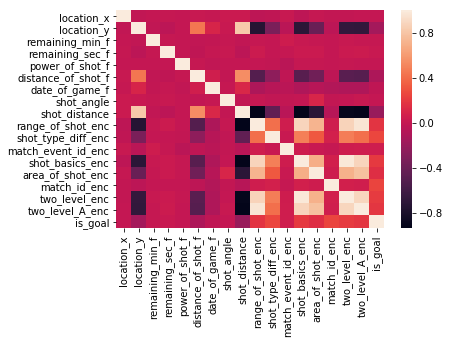

In [593]:
sns.heatmap(dat.corr())
plt.show()

In [213]:
importance.sort_values('imp')

,features,imp
5,knockout_match_f,0.000945
4,power_of_shot_f,0.007078
15,area_of_shot_enc,0.012466
7,game_season_f,0.014317
2,remaining_min_f,0.017385
11,match_event_id,0.017456
0,location_x,0.021848
9,shot_angle,0.022599
3,remaining_sec_f,0.025379
14,shot_basics_enc,0.029545


In [185]:
importance.sort_values('imp')

,features,imp
12,range_of_shot_fill_enc,0.009618
5,knockout_match_f,0.012445
14,shot_basics_enc,0.013037
15,area_of_shot_enc,0.014016
4,power_of_shot_f,0.031021
6,distance_of_shot_f,0.040594
7,game_season_f,0.049491
2,remaining_min_f,0.064247
0,location_x,0.067056
1,location_y,0.069240


In [ ]:
#base- 0.821
# params - 0.849(n_estimators=100,max_depth=10,min_samples_leaf=50,random_state=seed)
#(n_estimators=100,max_depth=10,min_samples_leaf=50,random_state=seed)